# Введение
Цель данного ноутбука заключается в создании модели, способной отличать кликбейтные заголовки от обычных.

# Импорт библиотек

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
Мы рассматриваем 2 источника данных: Kaggle и YandexGPT.

## Датасеты (YandexGPT)

In [21]:
file_1 = 'files/yandexgpt_generated_1.csv'
file_2 = 'files/yandexgpt_generated_2.csv'
file_3 = 'files/yandexgpt_generated.csv'
files = [file_1, file_2, file_3]
columns = ['title', 'clickbait_title']

gpt_generated = [pd.read_csv(file_name, usecols=columns) for file_name in files]
gpt_generated = pd.concat(gpt_generated)

In [22]:
gpt_generated.sample(5)

,title,clickbait_title
3951,Роднина дала совет фигуристу после запрета на ...,Роднина раскрыла секрет успеха: что сказала ле...
10367,Отпуск в Турции обернулся для россиянина комой...,Шокирующие истории: российский турист впал в к...
16551,Назван главный признак опасности открытого Wi-Fi,Бесплатный Wi-Fi — это опасно! Эксперт рассказ...
636,Ведущая «Давай поженимся!» раскрыла закулисье ...,Роза Сябитова раскрыла тайные приёмы: как она ...
17449,Во Внуково сотни людей высадили из самолета бе...,Более 400 человек застряли в аэропорту Внуково...


#### Объединим две колонки в одну

In [23]:
not_clickbait = pd.DataFrame({'title': gpt_generated['title']})
not_clickbait['is_clickbait'] = 0

clickbait = pd.DataFrame({'title': gpt_generated['clickbait_title']})
clickbait['is_clickbait'] = 1

df = pd.concat([clickbait, not_clickbait])

In [24]:
df.sample(5)

,title,is_clickbait
8773,В НХЛ впервые за шесть лет шайбу забросил вратарь,0
3500,Шокирующая правда: что произошло с российскими...,1
13970,Эксперт положительно оценил решение суда по де...,0
4383,Назван простой способ избавиться от ржавчины,0
16083,Российский хоккеист попал в реанимацию после д...,0


## Датасет (Kaggle)

In [25]:
file_3 = 'files/kaggle.csv'
kaggle = pd.read_csv(file_3, engine='python', sep=';')
kaggle.sample(5)

,titles,target
356,"Как встретить 2024 год Дракона, чтобы притянут...",1
1033,Овечкин получил опасный удар по шее: что с ним,1
27,Эти вещи не понравятся Дракону: что запрещено ...,1
143,Галкин* удивил новостью о пополнении в семье,1
1631,"Медведев заявил, что поддержка Украины близитс...",0


In [26]:
kaggle.rename(columns={'titles' : 'title', 'target' : 'is_clickbait'}, inplace=True)
df = pd.concat([kaggle, df])

# Очистка данных

In [27]:
# Удалим заголовки, на которые YandexGPT не дал ответы
no_answer = 'К сожалению, я не могу ничего сказать об этом. Давайте сменим тему?'
df = df[~df['title'].str.startswith(no_answer)]

# Удалим ненужную информацию из заголовков
def clean(text):
    text = text.strip()
    # Ненужные знаки при генерации текста
    useless = ['«', '»', '**', '*', '<', '>']
    for to_change in useless:
        text = text.replace(to_change, '')
    # Фраза, предлагающая один из вариантов кликбейта
    if text.startswith('Вот один из'):
        parts = [part.strip() for part in text.split(':')[1:]]
        text = ' '.join(parts)
    # Фраза, предлагающая несколько вариантов кликбейта
    if text.startswith('Вот несколько'):
        text = ''.join(text.split(':')[1:])
        text = text.split('\n')[2] # Берем первый вариант
        text = text[3:].strip() # Убираем нумерацию
    # Плохой формат вывода
    if text.startswith('<Заголовок>'):
        text = text.split('\n')[2]
    return text.strip()

df['title'] = df['title'].apply(clean)

# Удалим дубликаты и пропуски
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [28]:
# Баланс классов после очистки
df['is_clickbait'].value_counts()

is_clickbait
0    22051
1    21118
Name: count, dtype: int64

In [29]:
# 10 прозвольных заголовков после очистки
for x in df.sample(10)['title']:
    print(x)

Инстасамка устроила скандал в такси и разбила стекло: таксист не выпустил блогершу из машины.
Федерацию хоккея Канады заподозрили в сокрытии изнасилования
Леонид Ярмольник: возвращение в КВН — это…
Шокирующий отдых в Стамбуле: россиянка раскрывает правду о желании всех туристов и местных!
Няня отказалась сидеть с детьми в единственный выходной, чтобы отдохнуть
Ливерпуль продаст одного из лидеров ради Мбаппе?
Скандал в Санкт-Петербурге: откровенная фотосессия в центре города — что грозит нарушительнице?
Сотрудница кол-центра потеряла работу из-за одной фразы: что же она сказала?
Презерватив помог австралийке выиграть золото Олимпиады
Шокирующая статистика: Московский регион — самый загруженный в мире по трафику на дорогах!


# Разбиение данных

In [30]:
text = df['title'].values
labels = df['is_clickbait'].values
text_train, text_test, y_train, y_test = train_test_split(text, labels, test_size=0.10)
text_train, train_val, y_train, y_val = train_test_split(text_train, y_train, test_size=0.15)

print(f'Train: X~{text_train.shape[0]}, y~{y_train.shape[0]}')
print(f'Test: X~{text_test.shape[0]}, y~{y_test.shape[0]}')
print(f'Validation: X~{train_val.shape[0]}, y~{y_val.shape[0]}')

Train: X~33024, y~33024
Test: X~4317, y~4317
Validation: X~5828, y~5828


# Токенизация

In [31]:
vocab_size = 5000
maxlen = 100
embedding_size = 32

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(text)

X_train = tokenizer.texts_to_sequences(text_train)
x_test = tokenizer.texts_to_sequences(text_test)
x_val = tokenizer.texts_to_sequences(train_val)

X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

# Обучение модели

In [32]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_1               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
callback = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=3,
        verbose=1
    )]

In [34]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=32, validation_data=(x_val, y_val), epochs=10, callbacks=callback)

Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 75s 69ms/step - accuracy: 0.8227 - loss: 0.3692 - val_accuracy: 0.9405 - val_loss: 0.1700
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 78s 66ms/step - accuracy: 0.9569 - loss: 0.1292 - val_accuracy: 0.9420 - val_loss: 0.1608
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 80s 65ms/step - accuracy: 0.9663 - loss: 0.1025 - val_accuracy: 0.9406 - val_loss: 0.1623
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.9744 - loss: 0.0777 - val_accuracy: 0.9406 - val_loss: 0.1688
Epoch 5/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 66s 64ms/step - accuracy: 0.9772 - loss: 0.0662 - val_accuracy: 0.9387 - val_loss: 0.1900
Epoch 5: early stopping


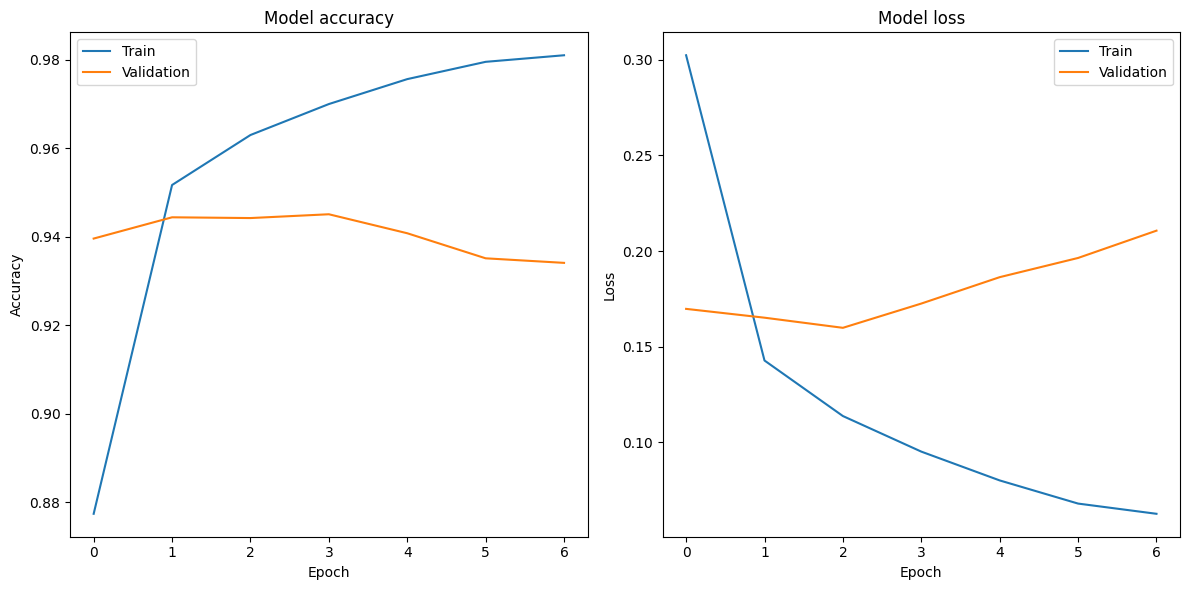

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


# Проверка модели

In [19]:
predictions_probability = model.predict(x_test)
predictions = [round(x[0]) for x in predictions_probability] # округляем до 0 или 1
print(classification_report(y_test, predictions))

135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2221
           1       0.94      0.92      0.93      2096

    accuracy                           0.93      4317
   macro avg       0.94      0.93      0.93      4317
weighted avg       0.93      0.93      0.93      4317



# Сохраняем модель

In [105]:
model.save('clickbait_classifier.keras')
df['title'].to_csv('loaded_text.csv', index=False) # вспомогательный файл